In [1]:
import nltk, string, openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm

from blurb_sim import cosine_sim

In [2]:
# Read in data, extract the old and new blurbs
data = pd.read_excel('../data.ods', engine = 'odf').dropna().to_numpy()
old_blurbs = data[:, 0].tolist()
new_blurbs = data[:, 1].tolist()

print(f'We have {len(old_blurbs)} blurbs to analyse')

We have 991 blurbs to analyse


In [3]:
# Compute the similarity scores, see blurb_sim.py for implementation
similarities = np.zeros(len(old_blurbs))
for i in tqdm(range(len(old_blurbs))):
    similarities[i] = cosine_sim(old_blurbs[i], new_blurbs[i])

  0%|          | 0/991 [00:00<?, ?it/s]

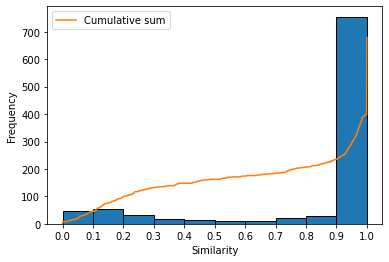

In [4]:
# Looks like the vast majority of the blurbs are very similar (0.9+)
granularity = 1000
num_less = np.zeros(granularity)
for index, num in enumerate(np.linspace(0, 1, granularity)):
    num_less[index] = sum(similarities < num)
    
plt.hist(similarities, ec = 'black', density = False)
plt.plot(np.linspace(0, 1, granularity), num_less, label = 'Cumulative sum')
plt.xticks(np.arange(0, 1.1, step = 0.1))
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [5]:
# Looks like many of the documents are actually exactly the same.
# Floating point errors mean that values that should be 1 often erroneously end up as 0.9999999 etc
print(f'It turns out that {sum(similarities > 0.999)} out of {len(old_blurbs)} blurbs are exactly equal.')

It turns out that 594 out of 991 blurbs are exactly equal.


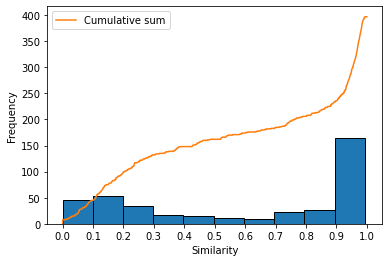

In [6]:
# How about just the ones that arent exactly the same. Lets see how sharp the fall actually is.
granularity = 1000
num_less = np.zeros(granularity)
for index, num in enumerate(np.linspace(0, 1, granularity)):
    num_less[index] = sum(similarities[similarities < 0.999] < num)
    
plt.hist(similarities[similarities < 0.999], ec = 'black', density = False)
plt.plot(np.linspace(0, 1, granularity), num_less, label = 'Cumulative sum')
plt.xticks(np.arange(0, 1.1, step = 0.1))
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# It looks like that by setting the threshold at around 0.8, we would halve the size of the
# data. This is after already detecting and removing those blurbs that are actually exactly equal.
# If we take this into account, the data size would be about a fifth.

In [7]:
# Lets write a function to compare the old and new blurbs, as well as print the similarity score

def compare_blurbs(index, similarity = False):
    """Print out the two blurbs, as well as their similarity score if requested.
    
    Parameters
    ----------
    index: integer greater than or euqal to 0
        the index of which to query
    
    similarty: boolean
        whether or not the similarity score should be printed
        
    Yields
    --------
    The data index, the two blurbs, and optionally, the similarity score are printed to the console
    """
    print('----------------------------------------------------------------------'\
          '------------------------------------------------------')
    print(f'Index: {index} \n')
    if similarity:   
        print(f'Similarity: {round(cosine_sim(old_blurbs[index], new_blurbs[index]), 3)}\n')
    print(old_blurbs[index], '\n')
    print(new_blurbs[index], '\n')

compare_blurbs(0, similarity = True)

----------------------------------------------------------------------------------------------------------------------------
Index: 0 

Similarity: 0.453

Established in Scotland in 1987, Orion Group has achieved consistent growth over the ensuing 31 years and is now an international leader in the provision of personnel to a number of industry sectors.Today Orion Group manages the placement of thousands of contractors and permanent personnel every year via their worldwide network of offices throughout Europe, the Americas, the Middle East, Asia Pacific and Africa.Orion provide specialist recruitment services across a range of sectors including; Life Sciences, New Energies, Oil and Gas, Construction & Infrastructure, Mining, Nuclear, Power & Utilities, Marine, Rail, IT, Finance, Office. Orion has the market intelligence and the experience necessary to take a holistic approach to project delivery – managing manpower provision from start to finish. 

Established in Scotland in 1987, Orion

In [ ]:
# Now lets see if the blurbs under this threshold look to be different enough
threshold = 0.8

for index, similarity in enumerate(similarities):
    if similarity < threshold:
        compare_blurbs(index, similarity = True)
        
# Scrolling through these the theshold of 0.8 seems to be doing a good job of removing all insubstantial changes.
# The threshold could probably be even more stringent, but here at least we are catching substantial changes, even if
# it wouldnt make a significant difference to how a company is perceived

In [ ]:
# Lets see those between 0.8 and 0.9
lower_threshold = 0.8
upper_threshold = 0.9

for index, similarity in enumerate(similarities):
    if similarity < upper_threshold and similarity > lower_threshold:
        compare_blurbs(index, similarity = True)
        
# Scrolling through I can't see any here that I would think make a significant difference to how a company is perceived

In [10]:
# Now lets finish by writing a function that does every step, and outputs the new data file

def similarity_subset(input_data_path, output_data_path, threshold = 0.8, return_ = False):
    """Function to load data consisting of two columns, the first containing old company blurbs
    the second containing new blurbs, work out their similarity and return a new data file consisting 
    of only those blurbs that are more dissimilar than some user-specified threshold.
    
    Parameters
    ----------
    input_data_path: string
        the path to the data file, an excel table
    
    output_data_path: string
        the path where you want save the new data file e.g. './new_data.ods'
    
    threshold: float between 0 and 1
        the threshold at which we filter out a blurb for not being similar enough,
        the higher the threshold, the more similar we allow blurbs to be
        
    return_: boolean
        decides whether or not the new dataset is returned
    """
    # Read in data, drop the empty rows
    data = pd.read_excel(input_data_path, engine = 'odf').dropna().to_numpy()
    
    N = data.shape[0]
    print(f'Number of blurbs: {N}')
    
    # Remove those rows that are identical
    data = data[data[:, 0] != data[:, 1]]
    print(f'Removed {N - data.shape[0]} identical blurbs...')
    
    # Extract remaining blurbs
    old_blurbs = data[:, 0].tolist()
    new_blurbs = data[:, 1].tolist()
    
    # Compute similarities and remove the rows that are below the threshold
    print('Computing similarities of remaining blurbs...')
    similarities = np.zeros(len(old_blurbs))
    for i in tqdm(range(len(old_blurbs))):
        similarities[i] = cosine_sim(old_blurbs[i], new_blurbs[i])
    
    M = sum(similarities < threshold)
    print(f'Remaining number of blurbs: {M}. Total reduction of {round((N - M)/N * 100, 2)}%')
    
    print(f'Saving file to the path {output_data_path}')
    # Find those blurbs where the similarity is less than our threshold, 
    # and output them to a new excel file
    threshed_indexes = np.where(similarities < threshold)
    new_data = pd.DataFrame( data[threshed_indexes] )
    new_data.to_excel(output_data_path,
                      index = False,
                      header = ['Old - Own blurb from the bridge',
                                'New - Own blurb you would copy paste onto the bridge'])
    
    # If we wanted to return the new dataset, return it
    if return_:
        return new_data

In [11]:
similarity_subset('../data.ods', '../new_data.ods', 0.5)

Number of blurbs: 991
Removed 558 identical blurbs...
Computing similarities of remaining blurbs...


  0%|          | 0/433 [00:00<?, ?it/s]

Remaining number of blurbs: 162. Total reduction of 83.65%
Saving file to the path ../new_data.ods
